# **1️. Montaje de Google Drive**

Conectamos Colab a mi Google Drive para acceder a archivos locales como el video de prueba.

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Instalación de librerías necesarias**

Instalamos PyTorch, OpenCV, Segment Anything y dependencias adicionales.

In [69]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib tqdm imageio
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

  Preparing metadata (setup.py) ... done


# **3️. Clonación del repositorio SAM3D y preparación**

Clonamos SegmentAnything3D y descargamos el modelo preentrenado.

In [70]:
!git clone https://github.com/Pointcept/SegmentAnything3D.git
%cd SegmentAnything3D

Cloning into 'SegmentAnything3D'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 182 (delta 37), reused 29 (delta 29), pack-reused 126 (from 1)
Receiving objects: 100% (182/182), 12.48 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/SegmentAnything3D/SegmentAnything3D/SegmentAnything3D


In [71]:
!mkdir checkpoints

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth \
-O checkpoints/sam_vit_b.pth

print("Modelo descargado")

Modelo descargado


# **4️.Comprobación de existencia del video**

Indicamos el path del archivo en google drive y confirmamos que existe antes de procesarlo.

In [72]:
video_path = "/content/drive/MyDrive/DJI_20251227113309_0010_D - SAM3D Test.mp4"

import os
print("Video exists:", os.path.exists(video_path))

Video exists: True


# **5️. Extracción de frames del video**

Extraemos los primeros 8 frames del video, reducimos la resolución para optimizar procesamiento.

In [73]:
import cv2
import os

frames_dir = "/content/sam3d_frames"
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)

# Verificar total de frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames in video:", total_frames)

# Extraer primeros 8 frames
max_frames = 8
count = 0

while True:

    ret, frame = cap.read()

    if not ret:
        print("No more frames or error")
        break

    # Reducir resolución
    frame_small = cv2.resize(frame, (640, 360))

    save_path = f"{frames_dir}/frame_{count:03d}.jpg"

    cv2.imwrite(save_path, frame_small)

    print("Saved:", save_path)

    count += 1

    if count >= max_frames:
        break

cap.release()

print("Total frames saved:", count)

Total frames in video: 863
Saved: /content/sam3d_frames/frame_000.jpg
Saved: /content/sam3d_frames/frame_001.jpg
Saved: /content/sam3d_frames/frame_002.jpg
Saved: /content/sam3d_frames/frame_003.jpg
Saved: /content/sam3d_frames/frame_004.jpg
Saved: /content/sam3d_frames/frame_005.jpg
Saved: /content/sam3d_frames/frame_006.jpg
Saved: /content/sam3d_frames/frame_007.jpg
Total frames saved: 8


# **6. Visualización de frames extraídos**

Mostramos los frames extraídos y los mostramos para conocerlos.

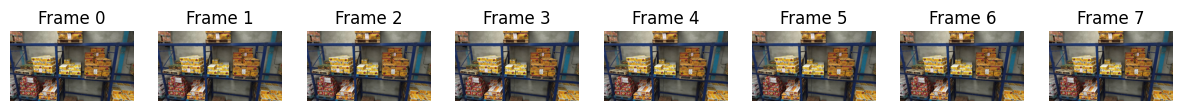

In [74]:
import matplotlib.pyplot as plt
import glob

frames = sorted(glob.glob(frames_dir + "/*.jpg"))

plt.figure(figsize=(15,5))

for i, frame_path in enumerate(frames):

    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1,len(frames),i+1)
    plt.imshow(img)
    plt.title(f"Frame {i}")
    plt.axis("off")

plt.show()

# **7️. Carga del modelo SAM3D en GPU**

Cargamos la arquitectura SAM y lo movemos a GPU para acelerar procesamiento.

In [75]:
import torch
import sys
import os

# Agregar SegmentAnything3D al path
sys.path.append("/content/SegmentAnything3D")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Path del checkpoint
checkpoint_path = "/content/SegmentAnything3D/checkpoints/sam_vit_b.pth"

# Cargar modelo
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)

# mover a GPU
device = "cuda"
sam.to(device)

print("SAM backbone cargado en:", device)

SAM backbone cargado en: cuda


# **8️. Configuración del generador de máscaras**

Creamos el generador de máscara automático con parámetros ajustados para detectar objetos de manera confiable.

In [76]:
mask_generator = SamAutomaticMaskGenerator(

    model=sam,

    points_per_side=70, #Numero de puntos por lado para generar la mascara

    pred_iou_thresh=0.82,  #Umbral de confianza para aceptar la mascara

    stability_score_thresh=0.95, #Umbral de estabilidad de la prediccion

    min_mask_region_area=1000  #Tamaño minimo del objeto a detectar

)

print("Mask generator listo")

Mask generator listo


# **9. Definir un tamaño máximo permitido**

In [77]:
max_mask_region_area =2000 #Ajuste para evitar tomar en cuenta areas muy grande como pared o partes del rack

# **10. Generación de máscaras para un frame**

Seleccionamos el primer frame y aplicamos el generador y partir de ahi hacemos el conteo de objetos, no de cajas.

In [78]:
import cv2
import matplotlib.pyplot as plt

# cargar primer frame
frame_path = "/content/sam3d_frames/frame_000.jpg"

image = cv2.imread(frame_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# generar máscaras
masks = mask_generator.generate(image_rgb)

print("Número de objetos detectados:", len(masks))

Número de objetos detectados: 214


# **11. Filtrar máscaras grandes**

Agregamos este filtro solo para optimizar un poco el conteo debido a que observamos que estaba eligiendo objetos que no eran cajas, estos objetos como la pared o frames del rack muy grande estaban siendo contabilizados.

In [79]:
# Filtrar máscaras generadas
filtered_masks = [mask for mask in masks if mask['segmentation'].sum() <= max_mask_region_area]

print("Objetos después de filtrar tamaños grandes:", len(filtered_masks))


Objetos después de filtrar tamaños grandes: 209


# **11. Visualización de máscaras con IDs**

Dibujamos contornos de cada máscara sobre la imagen y colocamos un ID sobre cada objeto para identificación visual.

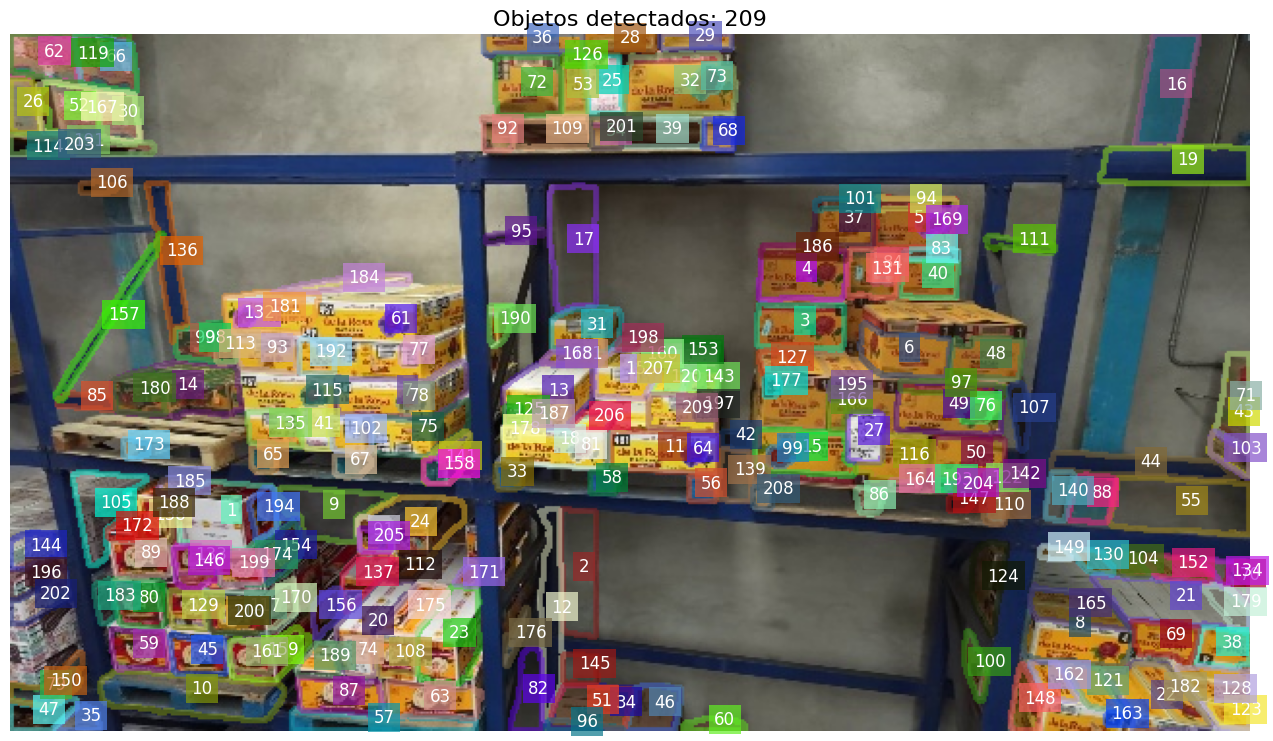

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Crear figura
plt.figure(figsize=(16,10))

# Mostrar la imagen original
plt.imshow(image_rgb)

# Generar colores consistentes para cada máscara
np.random.seed(42)
colors = np.random.rand(len(filtered_masks), 3)

for i, mask in enumerate(filtered_masks):
    m = mask['segmentation'].astype(np.uint8)

    # Crear contornos
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    color = (colors[i] * 255).astype(np.uint8).tolist()

    # Dibujar contornos sobre la imagen original
    image_overlay = image_rgb.copy()
    cv2.drawContours(image_overlay, contours, -1, color=color, thickness=2)

    # Calcular centro de la máscara para colocar el ID
    y, x = np.where(m)
    if len(x) > 0:
        cx = int(np.mean(x))
        cy = int(np.mean(y))
        plt.text(cx, cy, f"{i+1}",
                 color='white', fontsize=12,
                 bbox=dict(facecolor=tuple(c/255 for c in color), alpha=0.7, edgecolor='none'))

    # Mezclar la imagen original con los contornos para transparencia
    alpha = 0.5
    image_rgb = cv2.addWeighted(image_overlay, alpha, image_rgb, 1 - alpha, 0)

# Mostrar la imagen final con contornos y IDs
plt.imshow(image_rgb)
plt.title(f"Objetos detectados: {len(filtered_masks)}", fontsize=16)
plt.axis("off")
plt.show()
